In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import warnings
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [4]:
# 시각화 선명도
%config InlineBackend.figure_format = 'retina' 
# 한글설정 축의 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# warining 경고 안보이게
warnings.filterwarnings(action='ignore')
# warining 경고 보이게
# warnings.filterwarnings(action='default')

In [5]:
movies_processing = pd.read_csv('../프로젝트csv/movies.csv')

In [6]:
movies_processing['관객수_등급'] = pd.qcut(
    movies_processing['관람객수'], 
    q= 5, 
    labels=range(1, 6)  # 구간을 숫자로 변환 5단계
)
print(movies_processing[['관객수_등급','관람객수']])

     관객수_등급      관람객수
0         5  875001.0
1         5  206309.0
2         5  155562.0
3         5   42290.0
4         5   38131.0
...     ...       ...
6019      3     676.0
6020      3     674.0
6021      3     652.0
6022      3     609.0
6023      3     582.0

[6024 rows x 2 columns]


In [7]:
# 관객수_순위 타입변환
movies_processing['관객수_등급'] = movies_processing['관객수_등급'].astype(int)
print(movies_processing[['관객수_등급','관람객수']].sample(5))

      관객수_등급    관람객수
5772       4  4275.0
4829       3   784.0
1704       1     4.0
578        4  3130.0
42         3  1430.0


In [8]:
# 월_계절 컬럼 만들기
def movie_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

In [9]:
movies_processing['개봉월'] = pd.to_numeric(movies_processing['개봉월'], errors='coerce')
movies_processing['계절'] = movies_processing['개봉월'].apply(movie_season)
movies_processing['계절']

0       4
1       4
2       4
3       4
4       4
       ..
6019    3
6020    2
6021    3
6022    3
6023    2
Name: 계절, Length: 6024, dtype: int64

In [11]:
# 장르2를 만들어 번호와 이름이 같이 출력할수있게 딕셔너리로 변경
movies_genre = {movie:idx   for idx, movie in enumerate(movies_processing['장르'].unique())}
# movies_genre
movies_processing['장르2'] = movies_processing['장르'].map(movies_genre)
print(movies_processing[['장르', '장르2']].head())

      장르  장르2
0  애니메이션    0
1  애니메이션    0
2     액션    1
3    드라마    2
4  애니메이션    0


In [12]:
# 라벨인코딩 
le = LabelEncoder()
movies_processing['등급_le'] = le.fit_transform(movies_processing['등급'])
movies_processing['계절_le'] = le.fit_transform(movies_processing['계절'])

# 데이터 준비 
x = movies_processing[['장르2', '계절_le','총스크린수', '등급_le']]
y = movies_processing['관객수_등급']
# y 원핫인코딩
y = to_categorical(y) # y 원핫인코딩

In [13]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4819, 4), (4819, 6), (1205, 4), (1205, 6))

In [14]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)),  # 입력
    Dense(128, activation=
          'relu'),# 은닉층
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'), 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax') # 출력층
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 6)                 3

In [16]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  # 원-핫 인코딩된 y_train 사용 시
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)
# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_aud3-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          # 저장경로
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               # 저장 여부 로그 출력 (0:출력 안 함)

hist = model.fit(X_train, y_train, 
                 epochs=500, 
                 validation_split=0.2, 
                 callbacks=[checkpoint, earlyStopping])

Epoch 1/500
121/121 [==============================] - 2s 8ms/step - loss: 1.5905 - accuracy: 0.2659 - val_loss: 1.5419 - val_accuracy: 0.3205
Epoch 2/500
121/121 [==============================] - 1s 4ms/step - loss: 1.5251 - accuracy: 0.3102 - val_loss: 1.5084 - val_accuracy: 0.3299
Epoch 3/500
121/121 [==============================] - 1s 5ms/step - loss: 1.5160 - accuracy: 0.3245 - val_loss: 1.4899 - val_accuracy: 0.3340
Epoch 4/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4998 - accuracy: 0.3416 - val_loss: 1.4838 - val_accuracy: 0.3444
Epoch 5/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4941 - accuracy: 0.3437 - val_loss: 1.4741 - val_accuracy: 0.3558
Epoch 6/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4767 - accuracy: 0.3486 - val_loss: 1.4749 - val_accuracy: 0.3382
Epoch 7/500
121/121 [==============================] - 1s 4ms/step - loss: 1.4754 - accuracy: 0.3575 - val_loss: 1.4494 - val_accuracy: 0.3703

Epoch 58/500
121/121 [==============================] - 1s 5ms/step - loss: 1.3086 - accuracy: 0.4387 - val_loss: 1.3865 - val_accuracy: 0.4025
Epoch 59/500
121/121 [==============================] - 1s 6ms/step - loss: 1.2954 - accuracy: 0.4524 - val_loss: 1.3933 - val_accuracy: 0.4098
Epoch 60/500
121/121 [==============================] - 1s 5ms/step - loss: 1.3025 - accuracy: 0.4444 - val_loss: 1.3921 - val_accuracy: 0.4129
Epoch 61/500
121/121 [==============================] - 1s 6ms/step - loss: 1.2991 - accuracy: 0.4534 - val_loss: 1.3887 - val_accuracy: 0.4129
Epoch 62/500
121/121 [==============================] - 1s 5ms/step - loss: 1.2931 - accuracy: 0.4527 - val_loss: 1.4142 - val_accuracy: 0.3911
Epoch 63/500
121/121 [==============================] - 1s 5ms/step - loss: 1.2939 - accuracy: 0.4516 - val_loss: 1.4022 - val_accuracy: 0.4015
Epoch 64/500
121/121 [==============================] - 1s 5ms/step - loss: 1.2909 - accuracy: 0.4597 - val_loss: 1.4078 - val_accuracy:

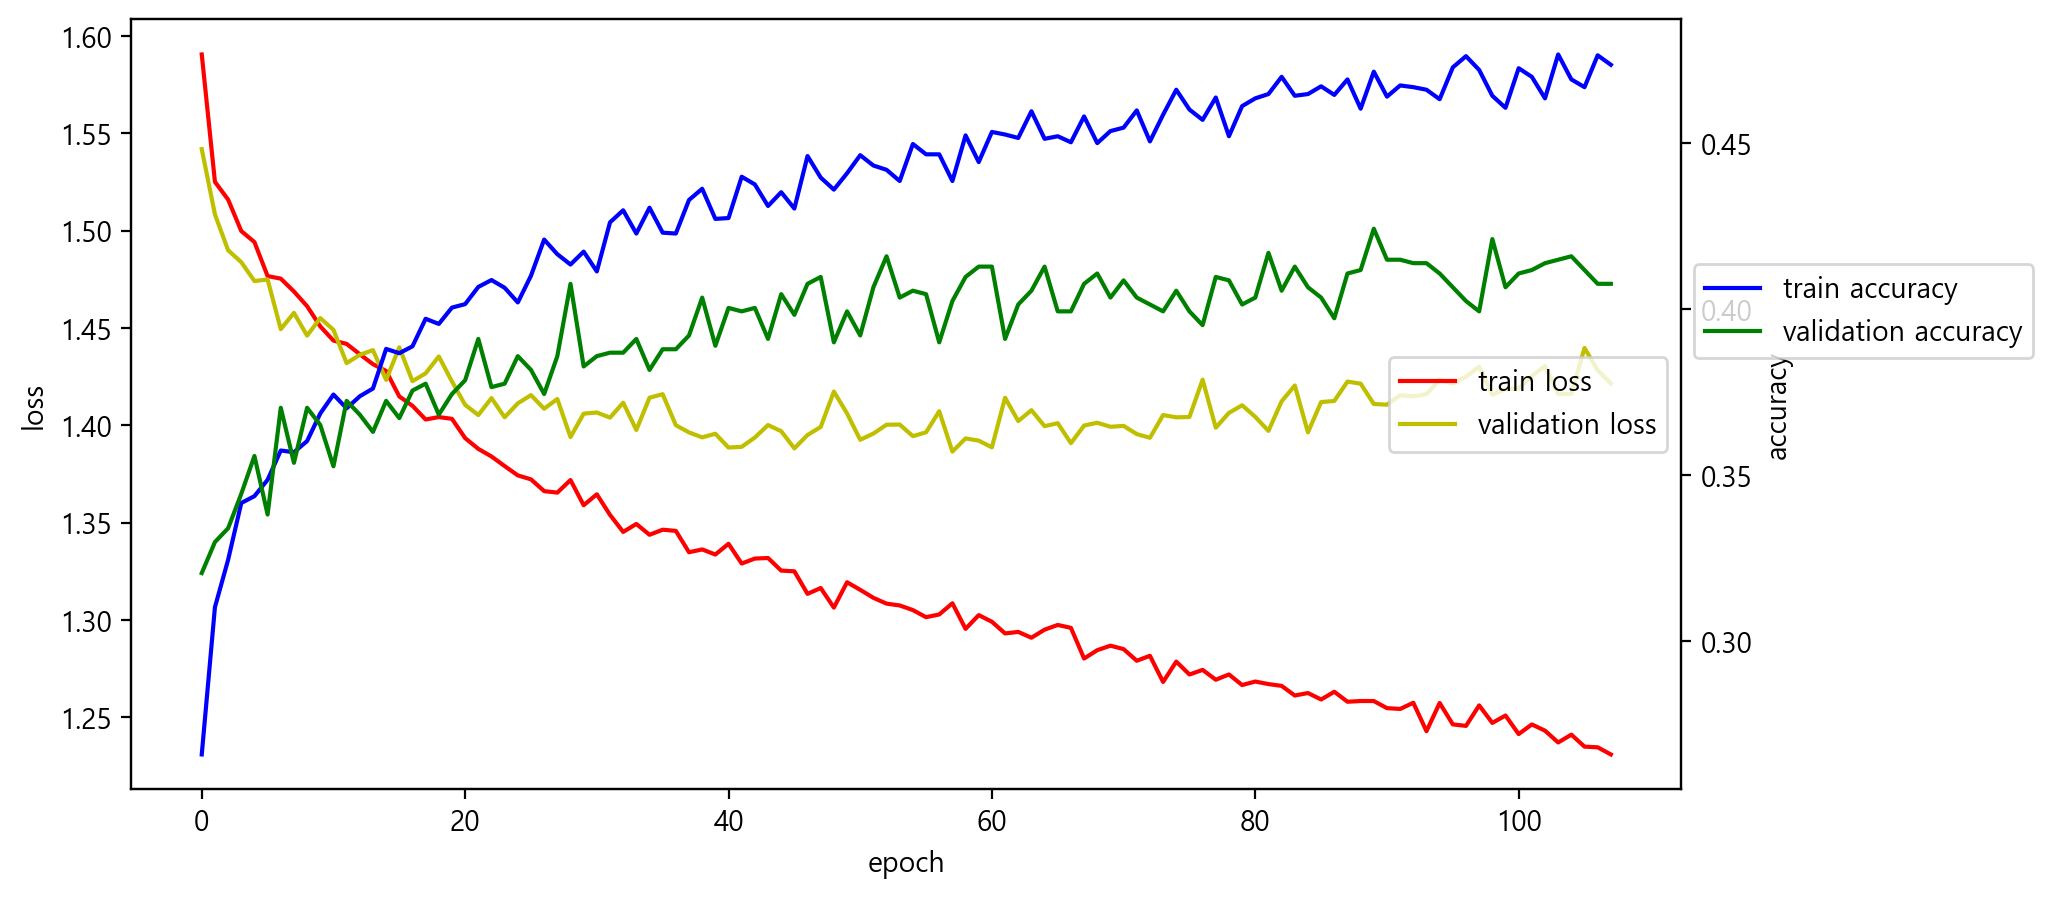

In [17]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [18]:
# 모델 평가하기 
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 3ms/step - loss: 1.4255 - accuracy: 0.4174
accuracy : 41.74 %


In [21]:
# 모델 평가 
# f1스코어
y_hat = model.predict(X_test).argmax(axis=1)
y_test = np.argmax(y_test, axis=1)
print(confusion_matrix(y_test, y_hat))
print('f1 score:', f1_score(y_test, y_hat, average='macro'))
# 크로스탭 
pd.crosstab(y_test, # 실제값(1차원) 
            y_hat.reshape(-1) # 예측값(1차원)    
           )

38/38 [==============================] - 0s 2ms/step
[[ 92  16  41  44  28]
 [ 59  43  47  50  42]
 [ 29  39  74  56  53]
 [ 15  13  42 138  64]
 [  9  11  15  29 156]]
f1 score: 0.40150285869137897


col_0,1,2,3,4,5
row_0,,,,,
1,92,16,41,44,28
2,59,43,47,50,42
3,29,39,74,56,53
4,15,13,42,138,64
5,9,11,15,29,156


In [22]:
movies_processing.to_csv('../프로젝트csv/movies.csv', index=False, encoding='utf-8')